In [2]:
using Gen, Plots, LinearAlgebra
using Distributions:fit

## Physics Simulation Utils

In [32]:
# Utility Functions
function getRotationMatrix(theta)
    return [cos(theta) -sin(theta); sin(theta) cos(theta)]
end

function makeBox(theta, scale)
    normals = [[0.0, -1.0], [1.0, 0.0], [0.0, 1.0], [-1.0, 0.0]]
    corners = [[1.0,1.0], [-1.0,1.0], [-1.0,-1.0], [1.0,-1.0]]
    for i in 1:4
        normals[i] = getRotationMatrix(theta) * normals[i]
        corners[i] = getRotationMatrix(theta) * corners[i] * scale
    end
    box = vcat(normals, corners)
    return box
end

function isInBox(box, point, scale)
    ABn = box[1] # normal defining AB (facing into the box)
    BCn = box[2]
    CDn = box[3]
    DAn = box[4]

    # dot product with normal (check which side of the hyperplane the point is on)
    mAB = Transpose(ABn) * point + scale
    mBC = Transpose(BCn) * point + scale
    mCD = Transpose(CDn) * point + scale
    mDA = Transpose(DAn) * point + scale

    # get around floating point error
    epsilon = 0.00001
    if mAB > -epsilon && mAB < epsilon
        mAB = 0.0
    end
    if mBC > -epsilon && mBC < epsilon
        mBC = 0.0
    end
    if mCD > -epsilon && mCD < epsilon
        mCD = 0.0
    end
    if mDA > -epsilon && mDA < epsilon
        mDA = 0.0
    end
    
    # dot product should be => 0 for all if the point is in the box
    if mAB < 0 
        return false
    end
     if mBC < 0
        return false
    end
    if mCD < 0
        return false
    end
    if mDA < 0
        return false
    end
    return true
end

# find the point of collision, normal at collision, and time of collision
# time of collision = Inf if there is no collision
function findIntersectionWithTrajectory(box, scale, O, V)
    # normals for each side of box
    ABn = box[1] # normal defining AB (facing inward)
    BCn = box[2]
    CDn = box[3]
    DAn = box[4]

    tAB = Inf
    tBC = Inf
    tBC = Inf
    tDA = Inf

    # time of collision with each side of box
    tAB = (-scale - (ABn[1]* O[1]) - (ABn[2]* O[2]))/(ABn[1]*V[1] + ABn[2]*V[2])
    tBC = (-scale - (BCn[1]* O[1]) - (BCn[2]* O[2]))/(BCn[1]*V[1] + BCn[2]*V[2])
    tCD = (-scale - (CDn[1]* O[1]) - (CDn[2]* O[2]))/(CDn[1]*V[1] + CDn[2]*V[2])
    tDA = (-scale - (DAn[1]* O[1]) - (DAn[2]* O[2]))/(DAn[1]*V[1] + DAn[2]*V[2])

    # filter out "collision" if it happens in negative time
    big = 10000000000
    if tAB == -Inf || tAB < 0 
        tAB = big
    end
    if tBC == -Inf || tBC < 0
        tBC = big
    end
    if tCD == -Inf || tCD < 0
        tCD = big
    end
    if tDA == -Inf || tDA < 0
        tDA = big
    end

    # find closest positive time of collision AKA the side of the box that the ball collides with
    current = big
    p = [big;big]
    n = [0.0;0.0]
    if tAB < current
        temp_p = O + V*tAB
        if isInBox(box, temp_p, scale)
            current = tAB
            p = O + V*tAB
            n = ABn
        end
    end
    if tBC < current
        temp_p = O + V*tBC
        if isInBox(box, temp_p, scale)
            current = tBC
            p = O + V*tBC
            n = BCn
        end
    end
    if tCD < current
        temp_p = O + V*tCD
        if isInBox(box, temp_p, scale)
            current = tCD
            p = O + V*tCD
            n = CDn
        end
    end
    if tDA < current
        temp_p = O + V*tDA
        if isInBox(box, temp_p, scale)
            current = tDA
            p = O + V*tDA
            n = DAn
        end
    end
    return (p, -n, current) #(point of intersection, -n so the n points outward, time of intersection)
end


# get the velocity after colliding with the object
function getOutVector(V_in, p, n)
    O_out = p 
    V_out = V_in - 2 * (Transpose(V_in) * n) * n # velocity after collision
    return O_out, V_out
end

# putting it all together
function getOutTrajectory(box, scale, O_in, V_in)
    p,n,t_out = findIntersectionWithTrajectory(box, scale, O_in, V_in) 
    O_out, V_out = getOutVector(V_in, p, n)
    return O_out, V_out, t_out
end

# for displaying
function grid(renderer::Function, traces)
    Plots.plot(map(renderer, traces)...)
end;

## Generative function for ball trajectory

In [33]:
# Generative function for noisy trajectory and noisy sample of ball
@gen function line_model(O_in, V_in, ts, jitter_x, jitter_y, box)
    jitterv = 0.15
    jitterpos = 0.05

    #Initial position
    O_in_x = ({:O_in_x} ~ normal(O_in[1], jitterpos))
    O_in_y = ({:O_in_y} ~ normal(O_in[2], jitterpos))

    # Velocity before collision with box (initial velocity)
    V_in_x = ({:V_in_x} ~ normal(V_in[1], jitterv)) 
    V_in_y = ({:V_in_y} ~ normal(V_in[2], jitterv))
    
    O_out, V_out, t_out = getOutTrajectory(box, 4, [O_in_x, O_in_y], [V_in_x, V_in_y])

    #Point of collision
    O_out_x = ({:O_out_x} ~ normal(O_out[1], jitterpos))
    O_out_y = ({:O_out_y} ~ normal(O_out[2], jitterpos))

    #Velocity after collision with box
    V_out_x = ({:V_out_x} ~ normal(V_out[1], jitterv))
    V_out_y = ({:V_out_y} ~ normal(V_out[2], jitterv))


    # Trajectory before collision
    function x_in(t)
        return O_in_x + V_in_x * t
    end
    function y_in(t)
        return O_in_y + V_in_y * t
    end

    # Trajectory after collision (if there is a collision)
    function x_out(t)
        return O_out_x + V_out_x * (t - t_out)
    end
    function y_out(t)
        return O_out_y + V_out_y * (t - t_out)
    end
    
    i_in_count= 0 # how many time steps before collision
    i_out_count = 0 # how many time steps after collision (if there is one)
    for (i, t) in enumerate(ts)
        if t < t_out #trajectory before hit object
            i_in_count = i
            ({(:x, i)} ~ normal(x_in(t), jitter_x))
            ({(:y, i)} ~ normal(y_in(t), jitter_y))
        else #trajectory after hit object
            i_out_count += 1
            ({(:x, i)} ~ normal(x_out(t), jitter_x))
            ({(:y, i)} ~ normal(y_out(t), jitter_y))
        end
    end

    return x_in, y_in, x_out, y_out, i_in_count, i_out_count, O_out, V_out, t_out
end;

In [34]:
function render_trace(trace; show_data=true)
    # Get trace arguments
    O_in, V_in, ts, jitter_x, jitter_y, box = get_args(trace)
    
    # Get outputs
    x_in, y_in, x_out, y_out, i_in_count, i_out_count, O_out, V_out, t_out = get_retval(trace)
    
    fig = plot(color="black", label=nothing,
                xlim=(-15, 15), ylim=(-15, 15))

    
    # plot the trajectories
    plot!(map(x_in, ts[1:i_in_count]), map(y_in, ts[1:i_in_count]), color="blue", alpha=1, label=nothing)
    plot!(map(x_out, ts[i_in_count:i_in_count+i_out_count]), map(y_out, ts[i_in_count:i_in_count+i_out_count]), color="green", alpha=1, label=nothing)
    

    # plot the box
    A, B, C, D, E = box[5], box[6],  box[7],  box[8],  box[5]
    plot!([A[1],B[1],C[1],D[1],E[1]],[A[2],B[2],C[2],D[2],E[2]],
      color=:red, linewidth=2, linestyle=:solid, label="Collision box")


    # plot the noisy samples along the trajectories
    if show_data
        x_in = [trace[(:x, i)] for i=1:i_in_count]
        y_in = [trace[(:y, i)] for i=1:i_in_count]
        scatter!(x_in, y_in, c="blue", label="In trajectory")

        if i_out_count > 0
            x_out = [trace[(:x, i)] for i=i_in_count:i_in_count+i_out_count]
            y_out = [trace[(:y, i)] for i=i_in_count:i_in_count+i_out_count]
            scatter!(x_out, y_out, c="green", label="Out trajectory")
        end
        
    end
    
    return fig
end;

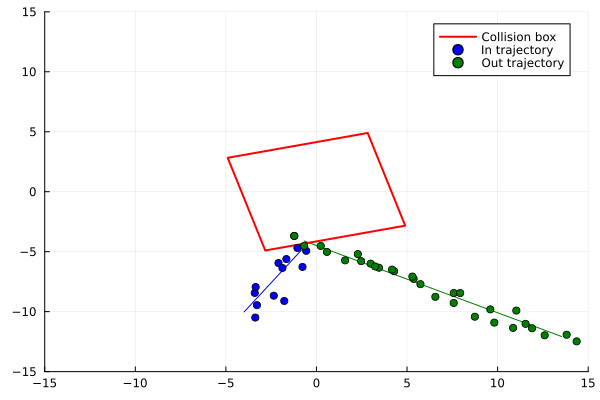

In [73]:
scale = 4
theta = 15*0.0174533 # degrees to radians
box = makeBox(theta,scale) 
O_in = [-4.0;-10.0]
V_in = normalize([3.0,4.0])
# O_out, V_out, t_out = getOutTrajectory(box, scale, O_in, V_in)

ts = [0:0.5:20;]
jitter_x = 0.5
jitter_y = 0.5
x_in, y_in, x_out, y_out, i_in_count, i_out_count, O_out, V_out, t_out = line_model(O_in, V_in, ts, jitter_x, jitter_y, box)
trace = Gen.simulate(line_model, (O_in, V_in, ts, jitter_x, jitter_y, box));
choices = Gen.get_choices(trace)
all_traj = [(trace[(:x, i)],trace[(:y, i)]) for i=1:i_in_count+i_out_count]
all_traj_x = map(x->x[1], all_traj)
all_traj_y = map(x->x[2], all_traj)
render_trace(trace)

## Inference on ball trajectory and collision angle using bayesian linear regression (known collision time)

In [38]:
# do posterior inference. Conditioned on the before-collision data points, the after-collision data points, guess the
# before-collision and after-collision trajectories
function do_inference(model, xs, ys, amount_of_computation, O_in, V_in, ts, jitter_x, jitter_y, box)
    observations = Gen.choicemap()
    for (i, x) in enumerate(xs)
        observations[(:x, i)] = x
    end
    for (i, y) in enumerate(ys)
        observations[(:y, i)] = y
    end
    
    # Call importance_resampling to obtain a likely trace consistent with our observations.
    (trace, _) = Gen.importance_resampling(model, (O_in, V_in, ts, jitter_x, jitter_y, box), observations, amount_of_computation);
    return trace
end;

In [58]:
function getTheta2(bisector)
    angle = 0
    if bisector[1] >= 0 && bisector[2] >= 0  #quadrant 1
        angle = acos(dot(bisector,[1.0;0.0]))
    elseif bisector[1] <= 0 && bisector[2] >= 0 # quadrant 2
        angle = acos(dot(bisector,[0.0;1.0]))
    elseif bisector[1] <= 0 && bisector[2] <= 0 #quadrant 3
        angle = acos(dot(bisector, [-1.0;0.0]))
    else
        angle = acos(dot(bisector,[0.0;-1.0])) # quadrant 4
    end
    return angle
end

getTheta2 (generic function with 1 method)

In [39]:
# calculates the angle bisector of the in-trajectory and out-trajectory to infer the normal of the side of the box
# based off of the inferred normal, calculates the rotation (theta) of the box
function getTheta(trace)
    x_in, y_in, x_out, y_out, i_in_count, i_out_count = get_retval(trace)
    x1 = x_in(ts[1])
    y1 = y_in(ts[1])
    x2 = x_in(ts[i_in_count])
    y2 = y_in(ts[i_in_count])
    x3 = x_out(ts[i_in_count+1])
    y3 = y_out(ts[i_in_count+1])
    x4 = x_out(ts[i_in_count+i_out_count])
    y4 = y_out(ts[i_in_count+i_out_count])
    
    AB = normalize([x1;y1]-[x2;y2]) 
    BC = normalize([x4;y4]-[x3;y3])
    bisector = normalize(AB + BC) # tail to tail

    angle = 0
    if bisector[1] >= 0 && bisector[2] >= 0  #quadrant 1
        angle = acos(dot(bisector,[1.0;0.0]))
    elseif bisector[1] <= 0 && bisector[2] >= 0 # quadrant 2
        angle = acos(dot(bisector,[0.0;1.0]))
    elseif bisector[1] <= 0 && bisector[2] <= 0 #quadrant 3
        angle = acos(dot(bisector, [-1.0;0.0]))
    else
        angle = acos(dot(bisector,[0.0;-1.0])) # quadrant 4
    end
    return angle
end

getTheta (generic function with 1 method)

In [40]:
function inferTheta(box, O_in, V_in, ts, jitter_x, jitter_y)
    scale = 4
    O_out, V_out, t_out = getOutTrajectory(box, scale, O_in, V_in)
    x_in, y_in, x_out, y_out, i_in_count, i_out_count, O_out, V_out, t_out = line_model(O_in, V_in, ts, jitter_x, jitter_y, box)
    trace = Gen.simulate(line_model, (O_in, V_in, ts, jitter_x, jitter_y, box));
    choices = Gen.get_choices(trace)
    render_trace(trace)
    all_traj = [(trace[(:x, i)],trace[(:y, i)]) for i=1:i_in_count+i_out_count]
    infTrace = do_inference(line_model, map(x->x[1],all_traj), map(x->x[2],all_traj), 10, O_in, V_in, ts, jitter_x, jitter_y, box);
    sample_theta = getTheta(infTrace)
    rendered_inf = render_trace(infTrace)
    return sample_theta, rendered_inf
end

inferTheta (generic function with 1 method)

Guessed rotation of box: 0.24381038618788783

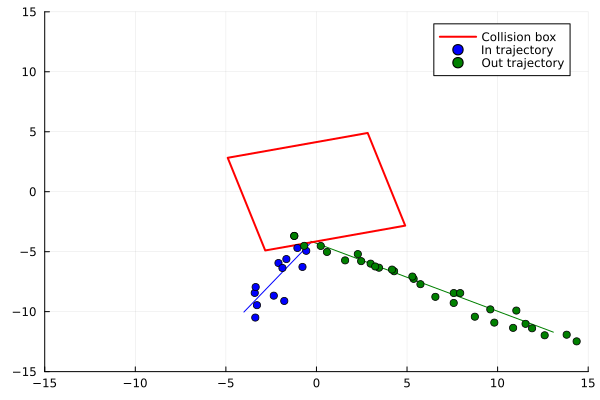

In [82]:
# continued from example above
all_traj = [(trace[(:x, i)],trace[(:y, i)]) for i=1:i_in_count+i_out_count]
infTrace = do_inference(line_model, map(x->x[1],all_traj), map(x->x[2],all_traj), 500,O_in, V_in, ts, jitter_x, jitter_y, box);
rotation_knownCollisionTime = getTheta(infTrace)
print("Guessed rotation of box: ", rotation_knownCollisionTime)
render_trace(infTrace)

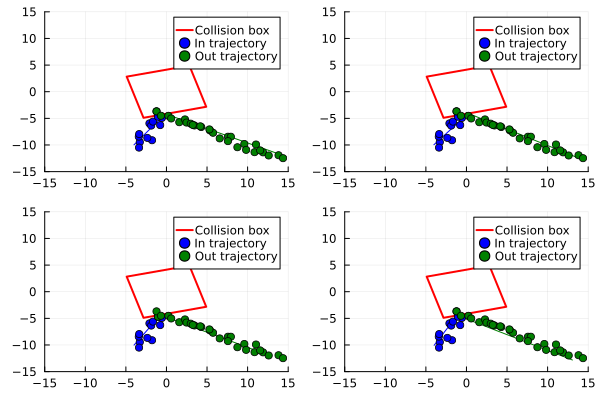

In [83]:
traces = [do_inference(line_model, map(x->x[1],all_traj), map(x->x[2],all_traj), 50, O_in, V_in, ts, jitter_x, jitter_y, box) for _=1:4];
grid(render_trace, (traces))

## Inference on ball trajectory and collision angle with unknown collision time

In [8]:
struct Interval
    l::Float64
    u::Float64
end

abstract type Node end
    
struct InternalNode <: Node
    left::Node
    right::Node
    interval::Interval
end

struct LeafNode <: Node
    x0::Float64
    y0::Float64
    angle::Float64
    interval::Interval
end

In [22]:
# get_value_at searches a binary tree for
# the leaf node containing some value.
function get_value_at(t::Float64, node::LeafNode)
    @assert t >= node.interval.l && t <= node.interval.u
    length = t - node.interval.l
    return [node.x0 + cos(node.angle)*length, node.y0 + sin(node.angle)*length]
end;

function get_value_at(t::Float64, node::InternalNode)
    @assert t >= node.interval.l && t <= node.interval.u
    if t <= node.left.interval.u
        get_value_at(t, node.left)
    else
        get_value_at(t, node.right)
    end
end;

function get_normal(left::LeafNode, right::LeafNode)
    # left's tail and right's head should roughly coincide
    # the "normal" is the bisector of the angle between, pointing "in"
    dir1 = [cos(left.angle), sin(left.angle)]
    dir2 = [cos(right.angle), sin(right.angle)]
    dirn = dir2 - dir1
    length = ((dirn[1])^2 + (dirn[2])^2)^.5
    return dirn/length
end;

In [103]:
# 2-piece linear
jitter = 0.05
velocity = 0.5

@gen function generate_leaf(l::Float64, u::Float64, x0::Float64, y0::Float64)
    interval = Interval(l, u)
    x0 = ({:x0} ~ normal(x0,jitter))
    y0 = ({:y0} ~ normal(y0,jitter))
    angle = ({:angle} ~ uniform(0,2*pi))
    return LeafNode(x0, y0, angle, interval)
end;

@gen function generate_segments(l::Float64, u::Float64, x0::Float64, y0::Float64)
    interval = Interval(l, u)
    frac = ({:frac} ~ beta(2, 2))
    llen = (u - l) * frac
    mid  = l + llen
    left = ({:left} ~ generate_leaf(l, mid, x0, y0))
    
    x1 = left.x0 + cos(left.angle)*llen
    y1 = left.y0 + sin(left.angle)*llen
    right = ({:right} ~ generate_leaf(mid, u, x1, y1))
    return InternalNode(left, right, interval)
end;

In [30]:
function do_collision_inference(model, (ts,x0,y0,), xs, ys, amount_of_computation)
    observations = Gen.choicemap()
    for (i, x) in enumerate(xs)
        observations[(:x, i)] = x
    end
    for (i, y) in enumerate(ys)
        observations[(:y, i)] = y
    end
    (trace, _) = Gen.importance_resampling(model, (ts,x0,y0,), observations, amount_of_computation);
    return trace
end;

# Our full model
@gen function changepoint_model(ts::Vector{Float64}, x0::Float64, y0::Float64)
    node = ({:tree} ~ generate_segments(minimum(ts), maximum(ts), x0, y0))
    # noise = ({:noise} ~ gamma(0.5, 0.5))
    noise = jitter
    for (i, t) in enumerate(ts)
        {(:x, i)} ~ normal(get_value_at(t, node)[1], noise)
        {(:y, i)} ~ normal(get_value_at(t, node)[2], noise)
    end
    return node
end;

In [25]:
function render_node!(node::LeafNode)
    length = node.interval.u - node.interval.l
    plot!([node.x0, node.x0+cos(node.angle)*length], [node.y0, node.y0+sin(node.angle)*length], label=nothing, linewidth=5)
end
function render_node!(node::InternalNode)
    render_node!(node.left)
    render_node!(node.right)
end;
function render_segments_trace(trace)
    node = get_retval(trace)
    fig = plot(xlim=xlim, ylim=ylim, aspect_ratio=:equal)
    render_node!(node)
    return fig
end;

function gridded(renderer::Function, traces)
    Plots.plot(map(renderer, traces)..., xlim=xlim, ylim=ylim, aspect_ratio=:equal)
end;

function render_changepoint_model_trace(trace; show_data=true)
    ts = Gen.get_args(trace)[1]
    node = Gen.get_retval(trace)
    fig = render_segments_trace(trace)
    render_node!(node)
    if show_data
        xs = [trace[(:x, i)] for i=1:length(ts)]
        ys = [trace[(:y, i)] for i=1:length(ts)]
        scatter!(xs, ys, c="gray", label=nothing, alpha=0.2, markersize=3)
    end
end;

#### Utils

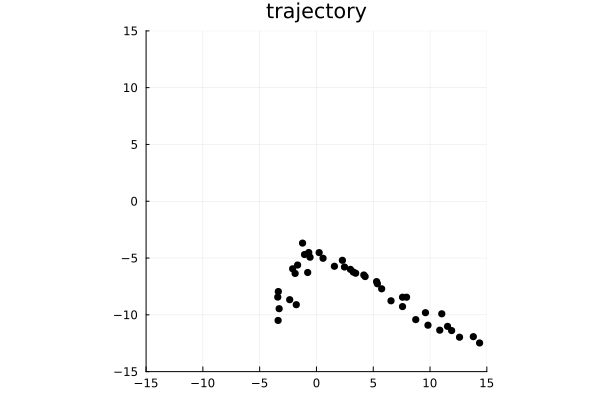

In [76]:
# Input - Trajectory Data (retrieved from physics model)
xs = all_traj_x
ys = all_traj_y
velocity = 0.5
jitter = 0.1;

# Set parametrization
@assert(length(xs) == length(ys))
num_points = length(xs);
num_t = num_points * velocity;
ts = collect(range(0., stop=num_t, length=num_points));

# Show trajectory
xlen = maximum(xs)-minimum(xs)
ylen = maximum(ys)-minimum(ys)
xlim = (-15,15)
ylim = (-15,15)
xy_plot = scatter(xs, ys, color="black", label=nothing, title="trajectory", xlim=xlim, ylim=ylim, aspect_ratio=:equal)
Plots.plot(xy_plot)

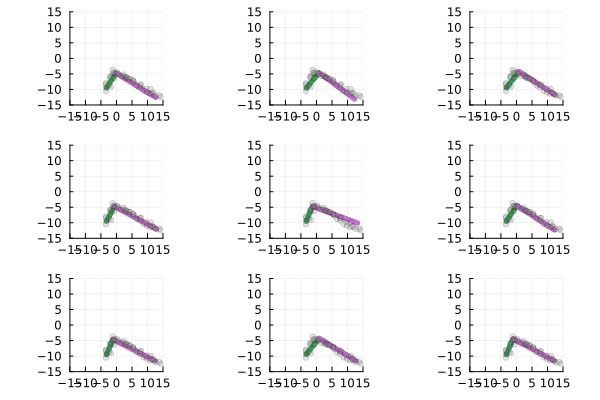

In [104]:
traces = [do_collision_inference(changepoint_model, (ts,xs[1],ys[1],), xs, ys, c) for c=10000:2000:26000];
gridded(render_changepoint_model_trace, traces)

In [105]:
node = Gen.get_retval(traces[9]);

intersection = [node.right.x0, node.right.y0]; # location of bounce
direction = get_normal(node.left, node.right); # direction of normal vector at bounce

println(intersection)
println(direction)

[-1.1403176181746022, -4.491096654717746]
[0.3283148845052196, -0.9445683334795446]


In [106]:
rotation_unknownCollisionTime = getTheta2(direction)

0.33451901482678836

## Box Rotation Inference

In [84]:
function createTrajectories(box_rot)
    lower_limit = 4*2^0.5 + 0.05
    initx = uniform(lower_limit,8)
    inity = uniform(lower_limit,8)
    if bernoulli(0.5)
        initx *= -1
    end
    if bernoulli(0.5)
        inity *= -1
    end
    O_in = [initx; inity]
    v = uniform(-0.0872665, 0.0872665)
    V_in = normalize(getRotationMatrix(v) * -O_in)
    box = makeBox(box_rot,4)
    ts = [0:0.5:20;]
    jitter_x = 0.5
    jitter_y = 0.5
    x_in, y_in, x_out, y_out, i_in_count, i_out_count, O_out, V_out, t_out = line_model(O_in, V_in, ts, jitter_x, jitter_y, box)
    trace = Gen.simulate(line_model, (O_in, V_in, ts, jitter_x, jitter_y, box))
    all_traj = [(trace[(:x, i)],trace[(:y, i)]) for i=1:i_in_count+i_out_count]
    return (all_traj, O_in, V_in)
end

createTrajectories (generic function with 1 method)

In [155]:
function collectDataKnownCollisionTime(box_rot, ts, trials)
    box = makeBox(box_rot,4)
    data = [createTrajectories(box_rot) for i in 1:trials]
    O_ins = map(x->x[2], data)
    V_ins = map(x->x[3], data)
    all_trajs = map(x->x[1], data)

    thetas = zeros(trials)
    # ts = [0:0.5:19.5;]
    jitter_x = 0.5
    jitter_y = 0.5

    
    fig = plot(color="black", label=nothing,
                xlim=(-15, 15), ylim=(-15, 15))
    for i in 1:trials
        infTrace = do_inference(line_model, map(x->x[1],all_trajs[i]), map(x->x[2],all_trajs[i]), 50, O_ins[i], V_ins[i], ts, jitter_x, jitter_y, box);
        thetas[i] = getTheta(infTrace)
        x_in, y_in, x_out, y_out, i_in_count, i_out_count, O_out, V_out, t_out = get_retval(infTrace)
        plot!(map(x_in, ts[1:i_in_count]), map(y_in, ts[1:i_in_count]), color="blue", alpha=1, label=nothing)
        plot!(map(x_out, ts[i_in_count:i_in_count+i_out_count]), map(y_out, ts[i_in_count:i_in_count+i_out_count]), color="green", alpha=1, label=nothing)
    end


    return thetas, fig
end

collectDataKnownCollisionTime (generic function with 2 methods)

In [156]:
function collectDataUnknownCollisionTime(box_rot, ts, trials)
    box = makeBox(box_rot,4)
    data = [createTrajectories(box_rot) for i in 1:trials]
    O_ins = map(x->x[2], data)
    V_ins = map(x->x[3], data)
    all_trajs = map(x->x[1], data)

    velocity = 0.5
    jitter = 0.1;

    thetas = zeros(trials)
    # ts = [0:0.5:20;]

    
    fig = plot(color="black", label=nothing,
                xlim=(-15, 15), ylim=(-15, 15))
    for i in 1:trials
        xs = map(x->x[1], all_trajs[i])
        ys = map(x->x[2], all_trajs[i])
        traces = [do_collision_inference(changepoint_model, (ts,xs[1],ys[1],), xs, ys, c) for c=10000:2000:26000];
        node = Gen.get_retval(traces[9]);
        intersection = [node.right.x0, node.right.y0]; # location of bounce
        direction = get_normal(node.left, node.right); # direction of normal vector at bounce
        rotation_unknownCollisionTime = getTheta2(direction)
        thetas[i] = rotation_unknownCollisionTime
    end


    return thetas
end

collectDataUnknownCollisionTime (generic function with 2 methods)

In [157]:
ts = [0:0.5:20;]
actual_box_rot = 60*0.0174533
trials = 5
rotation_guesses_from_known_collision_time, fig = collectDataKnownCollisionTime(actual_box_rot, ts, trials)
rotation_guesses_from_unknown_collision_time = collectDataUnknownCollisionTime(actual_box_rot, ts, trials)

5-element Vector{Float64}:
 0.8540747898447228
 1.0225633326014019
 1.1358022664187195
 1.034963669586929
 0.772052528086068

## Box rotation model

In [124]:
@gen function box_rotation_model(num_trials)
    box_rotation = ({:box_rotation} ~ uniform(0, pi/2))
    for i in 1:num_trials
        ({(:th, i)} ~ normal(box_rotation, 0.065)) # σ based on the experiment above
    end
    return box_rotation
end;

In [119]:
function do_inference_rotation(model, thetas, amount_of_computation)
    observations = Gen.choicemap()
    for (i, th) in enumerate(thetas)
        observations[(:th, i)] = th
    end
    (trace, _) = Gen.importance_resampling(model, (length(thetas), ), observations, amount_of_computation);
    return trace
end;

In [127]:
final_guess_from_known_collision_time = do_inference_rotation(box_rotation_model, rotation_guesses_from_known_collision_time, 20);
final_guess_from_unknown_collision_time = do_inference_rotation(box_rotation_model, rotation_guesses_from_unknown_collision_time, 20);

In [133]:
# final_guess_from_known_collision_time 
println("The real box rotation is: ", actual_box_rot * 57.2958, " degrees.") 
println("The guessed rotation from known collision time inference is: ", final_guess_from_known_collision_time[:box_rotation] * 57.2958, " degrees")
println("The guessed rotation from unknown collision time inference is: ", final_guess_from_unknown_collision_time[:box_rotation] * 57.2958, " degrees")


The real box rotation is: 60.0000471684 degrees.
The guessed rotation from known collision time inference is: 60.0466627166865 degrees
The guessed rotation from unknown collision time inference is: 59.26795148209956 degrees


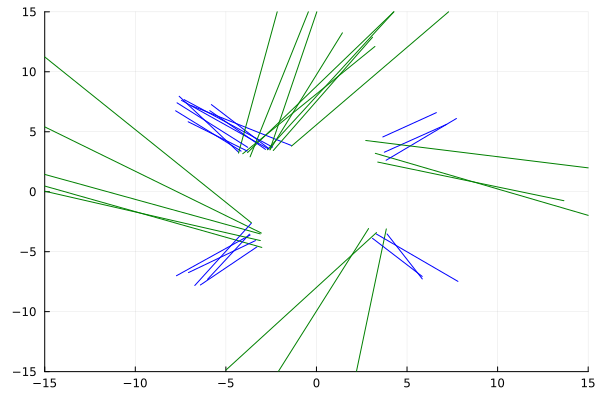

In [135]:
fig

## Overall results

### Guessed rotation vs real rotation

#### with known collision time

In [147]:
function test_result(num_trials)
    reals = zeros(100)
    guesses = zeros(100)
    for i in 1:100
        box_rot = uniform(0, pi/2)
        trials = num_trials
        thetas, fig = collectDataKnownCollisionTime(box_rot, trials)
        tr = do_inference_rotation(box_rotation_model, thetas, 20)
        reals[i] = box_rot * 57.2958
        guesses[i] = tr[:box_rotation] * 57.2958
    end
    return scatter(guesses, reals, c="red", label=nothing, xlabel = "Guessed rotation", ylabel = "Real rotation", title = string("# collisions: ", num_trials))
end

test_result (generic function with 1 method)

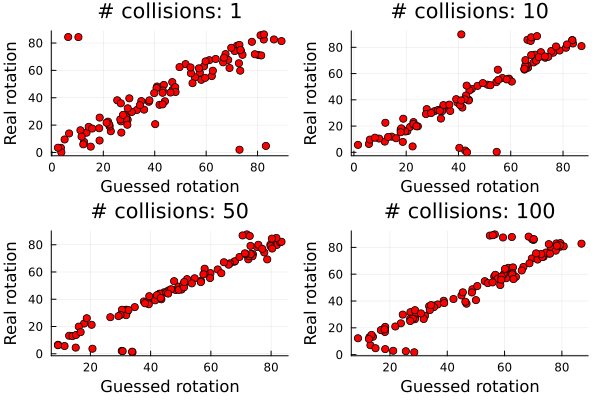

In [152]:
trials = [1,10,50,100]

# for displaying
function grid_res(renderer::Function, trials)
    Plots.plot(map(renderer, trials)...)
end;

grid_res(test_result, trials)

## Testing edge cases

#### 1 degree rotation

The real box rotation is: 1.00000078614 degrees. The guessed rotation is: 37.54312471137336 degrees

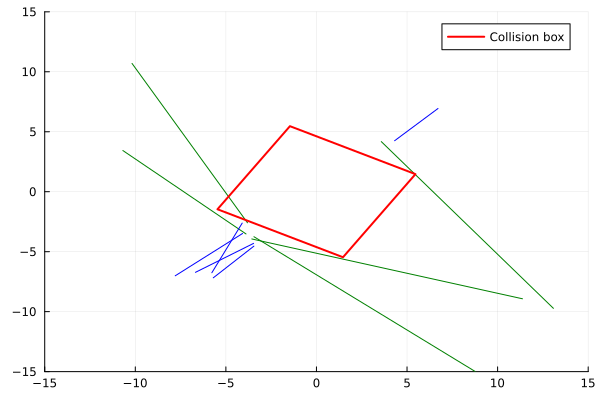

In [158]:
box_rot = 1 * 0.0174533 # 1 degree
trials = 5
thetas, fig = collectData(box_rot, trials)
tr = do_inference_rotation(box_rotation_model, thetas, 20)
print("The real box rotation is: ", box_rot * 57.2958, " degrees. The guessed rotation is: ", tr[:box_rotation] * 57.2958, " degrees") #prints in degrees
fig
    # plot the box
    A, B, C, D, E = box[5], box[6],  box[7],  box[8],  box[5]
    plot!([A[1],B[1],C[1],D[1],E[1]],[A[2],B[2],C[2],D[2],E[2]],
      color=:red, linewidth=2, linestyle=:solid, label="Collision box")

In [159]:
thetas * 57.2958 # guessed rotation

5-element Vector{Float64}:
 86.32942472821587
  9.251770285463367
  3.5290792626701593
 88.92631384039775
  1.7938285940942513

#### 89 degree rotation

The real box rotation is: 89.00006996646 degrees. The guessed rotation is: 49.71492586943114 degrees

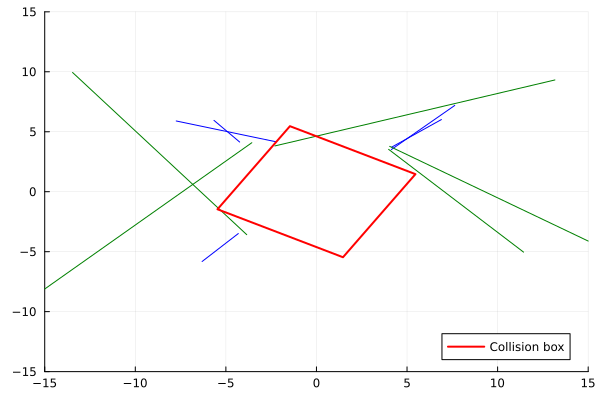

In [160]:
box_rot = 89 * 0.0174533 # 89 degrees
trials = 5
thetas, fig = collectData(box_rot, trials)
tr = do_inference_rotation(box_rotation_model, thetas, 20)
print("The real box rotation is: ", box_rot * 57.2958, " degrees. The guessed rotation is: ", tr[:box_rotation] * 57.2958, " degrees") #prints in degrees
fig
    # plot the box
    A, B, C, D, E = box[5], box[6],  box[7],  box[8],  box[5]
    plot!([A[1],B[1],C[1],D[1],E[1]],[A[2],B[2],C[2],D[2],E[2]],
      color=:red, linewidth=2, linestyle=:solid, label="Collision box")


In [161]:
thetas * 57.2958 # guessed rotation

5-element Vector{Float64}:
  1.0519627990339044
 88.71494567923118
 87.40206980721044
  2.0924613786336095
 87.49931539667294